In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from inflection import underscore
from datetime import datetime

# 1.0. Manual Tests

In [170]:
df = pd.read_csv("Ecommerce.csv")
df = df.drop('Unnamed: 8', axis=1)
df = df.dropna()

df.columns = [underscore(k) for k in df.columns.tolist()]
df.invoice_date = pd.to_datetime(df.invoice_date)

df['aux_date'] = df['invoice_date'].apply(lambda x: datetime(x.year, x.month, 1))
df['cohort_date'] = df.groupby('customer_id')['aux_date'].transform('min')

year_diff = df.aux_date.dt.year - df.cohort_date.dt.year
month_diff = df.aux_date.dt.month - df.cohort_date.dt.month

df['cohort_index'] = year_diff * 12 + month_diff + 1

df.cohort_date = df.cohort_date.astype('str')

In [171]:
df2 = df.groupby(['cohort_date', 'cohort_index'])['customer_id'].apply(pd.Series.nunique).reset_index()

df2 = df2.pivot_table(index='cohort_date', columns='cohort_index', values='customer_id')

df2 = df2.divide(df2.iloc[:, 0], axis=0).round(3)

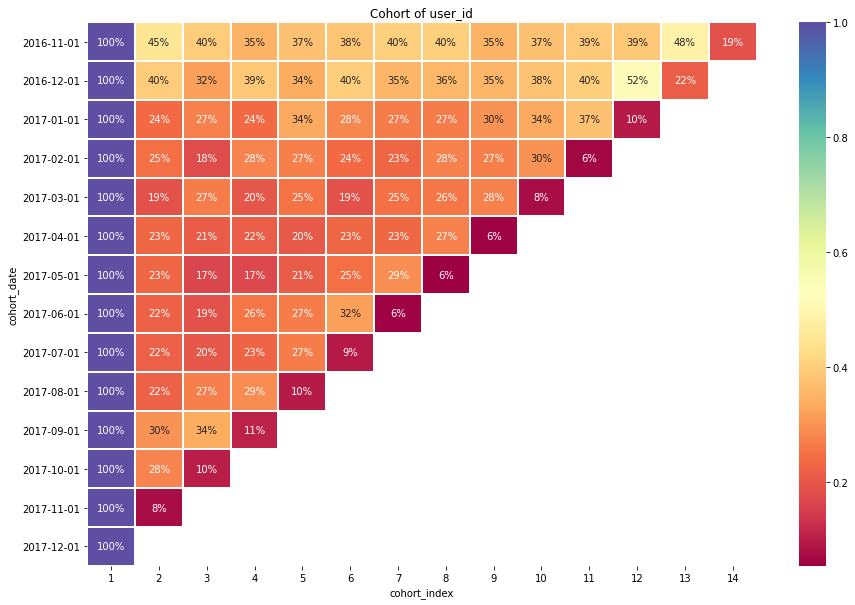

In [172]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df2, annot=True, cmap='Spectral', fmt='.0%', linewidths=2, ax=ax);
ax.set_title('Cohort of user_id');

In [184]:
df2 = df.groupby(['cohort_date', 'cohort_index'])['quantity'].mean().reset_index()

df2 = df2.pivot_table(index='cohort_date', columns='cohort_index', values='quantity').round(1)

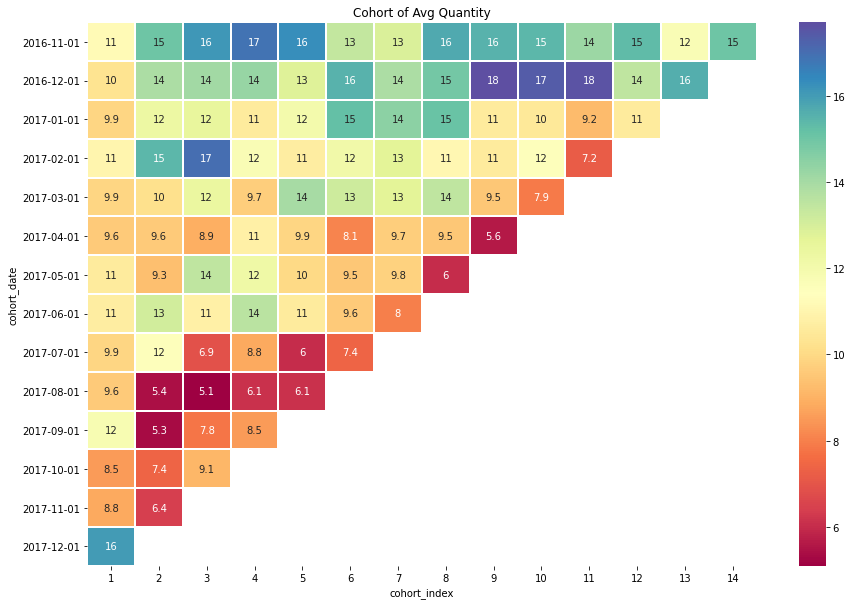

In [186]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df2, annot=True, cmap='Spectral', linewidths=2, ax=ax);
ax.set_title('Cohort of Avg Quantity');

# 2.0. Cohort Class

In [4]:
import pandas as pd
from seaborn import heatmap
from datetime import datetime
from matplotlib import pyplot as plt
from pandas.core.frame import DataFrame
#from abc import abstractmethod

class CohortPlots():
    #@abstractmethod
    
    def dataset_validation(self, df, date_col, selected_col, numerical_col=False, na=False) -> DataFrame:
        if na:
            df = df.dropna()
            if df.empty:
                raise ValueError(f"Dataframe with shape: {df.shape}")

        if type(df) != DataFrame:
            raise ValueError(f"Waiting a '{DataFrame.__name__}' is not a '{type(df).__name__}'")

        else:
            if numerical_col != False:
                if selected_col and date_col and numerical_col not in df.columns.tolist():
                    raise AttributeError(f"'{date_col}' or '{selected_col}' is not in Dataframe")

            else:
                if selected_col and date_col not in df.columns.tolist():
                    raise AttributeError(f"'{date_col}' or '{selected_col}' is not in Dataframe")

            if type(df[date_col][0]).__name__ != 'Timestamp':
                try:
                    df[date_col] = pd.to_datetime(df[date_col]) 
                except:
                    raise AttributeError(f"Datetime field of '{date_col}' impossible to convert to Pandas Datatime")

        return df

    def cohort_dataset(self, df, date_col, user_col) -> DataFrame:
        df['aux_date'] = df[date_col].apply(lambda x: datetime(x.year, x.month, 1))
        df['cohort_date'] = df.groupby(user_col)['aux_date'].transform('min')

        year_diff = df.aux_date.dt.year - df.cohort_date.dt.year
        month_diff = df.aux_date.dt.month - df.cohort_date.dt.month

        df['cohort_index'] = year_diff * 12 + month_diff + 1

        df.cohort_date = df.cohort_date.astype('str')

        return df

    def cohort_user_retention(self, df, date_col, user_col, na=False, ax=False) -> DataFrame:
        df = self.dataset_validation(df, date_col, user_col) 
        df = self.cohort_dataset(df, date_col, user_col)

        df = df.groupby(['cohort_date', 'cohort_index'])[user_col].apply(pd.Series.nunique).reset_index()
        df = df.pivot_table(index='cohort_date', columns='cohort_index', values=user_col)
        df = df.divide(df.iloc[:, 0], axis=0).round(3)

        if ax:
            heatmap(df, annot=True, cmap='Spectral', fmt='.0%', linewidths=2, ax=ax);
            ax.set_title('Cohort of ' + user_col);

        else:
            fig, ax = plt.subplots(figsize=(15, 10))
            heatmap(df, annot=True, cmap='Spectral', fmt='.0%', linewidths=2, ax=ax);
            ax.set_title('Cohort of ' + user_col);

        return df, ax

    def cohort_average(self, df, date_col, user_col, numeric_col, na=False, ax=False) -> DataFrame:
        df = self.dataset_validation(df, date_col, numeric_col) 
        df = self.cohort_dataset(df, date_col, user_col)

        df = df.groupby(['cohort_date', 'cohort_index'])[numeric_col].mean().reset_index()
        df = df.pivot_table(index='cohort_date', columns='cohort_index', values=numeric_col).round(1)

        if ax:
            heatmap(df, annot=True, cmap='Spectral', linewidths=2, ax=ax);
            ax.set_title('Cohort of Avg' + numeric_col);

        else:
            fig, ax = plt.subplots(figsize=(15, 10))
            heatmap(df, annot=True, cmap='Spectral', linewidths=2, ax=ax);
            ax.set_title('Cohort of Avg ' + numeric_col);

        return df, ax

## 2.1. Eccomerce Dataset

In [12]:
import warnings
import pandas as pd
from inflection import underscore
warnings.filterwarnings('ignore')

df = pd.read_csv("Ecommerce.csv")
df = df.drop('Unnamed: 8', axis=1)
df = df.dropna()

df.columns = [underscore(k) for k in df.columns.tolist()]
df.invoice_date = pd.to_datetime(df.invoice_date)

ch = CohortPlots()

In [13]:
df.head(2)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom


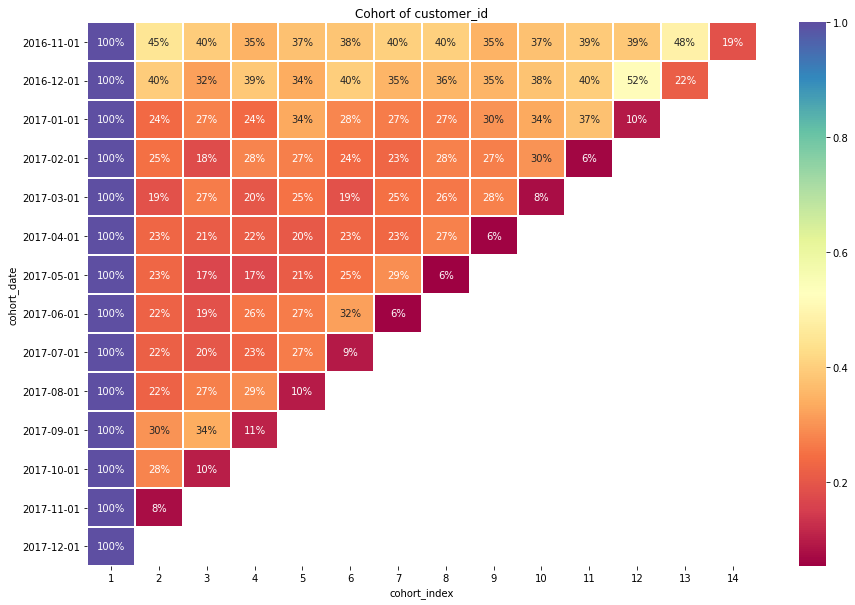

In [14]:
_, a = ch.cohort_user_retention(df, 'invoice_date', 'customer_id', na=True)

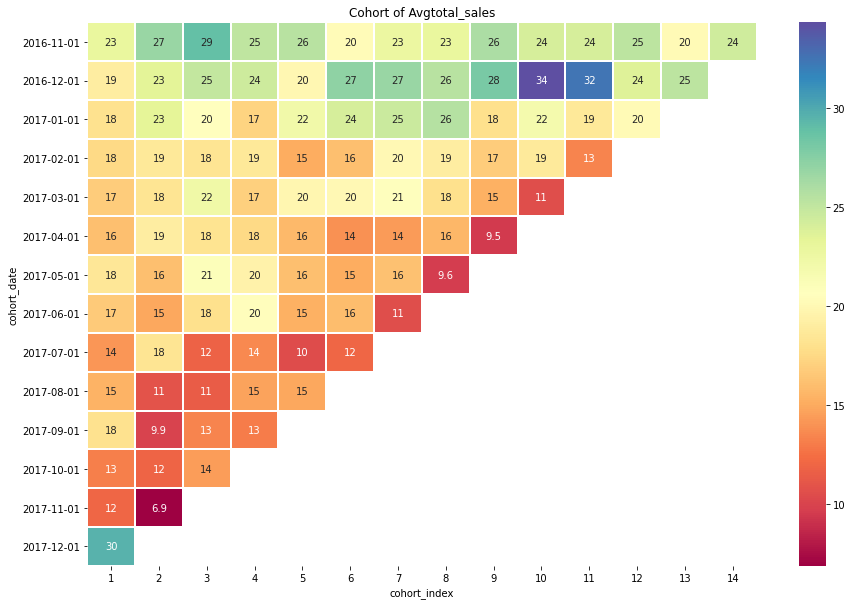

In [15]:
_, a = cohort_average(df, 'invoice_date', 'customer_id', 'total_sales')

## 2.2. Orders Dataset

In [13]:
import warnings
import pandas as pd
from inflection import underscore
warnings.filterwarnings('ignore')

df = pd.read_csv("orders.csv")
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna()

df.columns = [underscore(k) for k in df.columns.tolist()]

df.order_date = pd.to_datetime(df.order_date)

ch = CohortPlots()

In [14]:
df.head()

,order_id,order_date,user_id,total_charges,common_id,pup_id,pickup_date
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


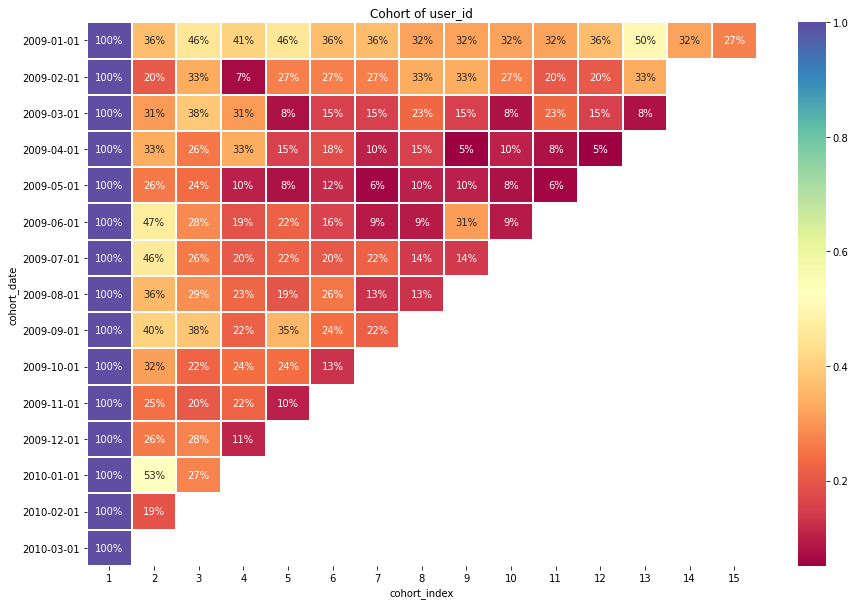

In [9]:
_, a = ch.cohort_user_retention(df, 'order_date', 'user_id')

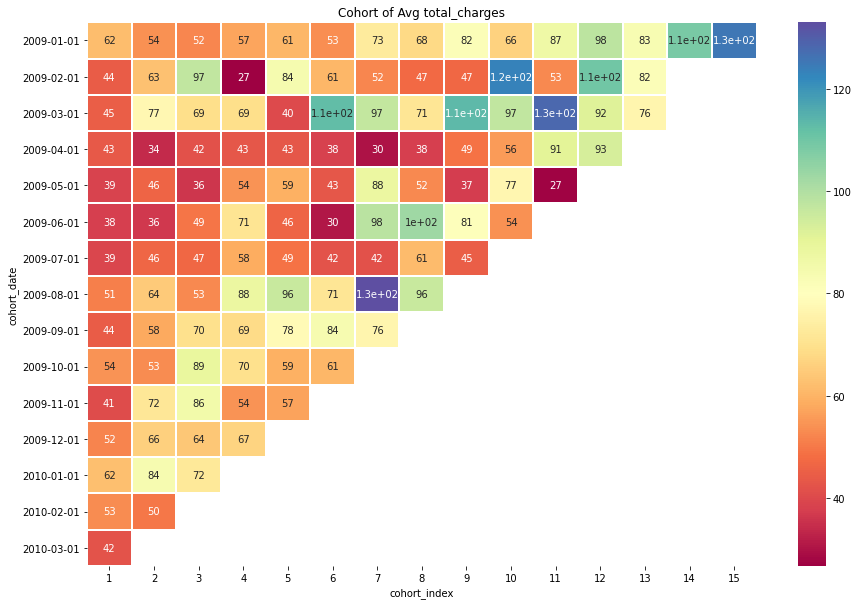

In [15]:
_, a = ch.cohort_average(df, 'order_date', 'user_id', 'total_charges')